# Прогнозирование мошенничества в сфере финансовых платежных услуг

Этот набор данных даёт некоторую информацию о растущем риске цифрового финансового мошенничества, подчеркивая сложность получения таких данных. Основная техническая проблема, которую он создает для прогнозирования мошенничества, заключается в крайне несбалансированном распределении между положительными и отрицательными классами в 6 миллионах строк данных. Цель этого анализа состоит в том, чтобы решить эту проблему путем детального изучения и очистки данных с последующим выбором подходящего алгоритма машинного обучения для устранения перекоса. Я показываю, что оптимальное решение, основанное на проектировании функций и деревьях решений с экстремальным градиентом, дает повышенную предсказательную способность 0,997, измеряемую площадью под кривой точного отзыва. Важно отметить, что эти результаты были получены без искусственного балансирования данных, что делает этот подход подходящим для реальных приложений.

# 1. Импорт

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
!pip install xgboost

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Импорт данных и правильное написание исходных заголовков столбцов для обеспечения согласованности

In [5]:

df = pd.read_csv('C:\\Users\\NIKITA\\Desktop\\nsii\\kneii\\PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


Необходимо проверять, есть ли какие-либо отсутствующие значения во фрейме данных. Оказывается, нет очевидных пропущенных значений, но, как видно ниже, это не исключает прокси с числовым значением, таким как 0.

In [6]:
df.isnull().values.any()

False

# 2. Исследовательский Анализ Данных

В этом разделе и до раздела 4 мы спорим с данными исключительно с использованием методов фреймов данных. Это самый краткий способ получить представление о наборе данных. Более подробные визуализации приведены в последующих разделах.

## 2.1. Какие типы транзакций являются мошенническими?

Я обнаружил, что из пяти типов транзакций мошенничество происходит только в двух из них: "ПЕРЕВОД", когда деньги отправляются клиенту / мошеннику, и "ОБНАЛИЧИВАНИЕ", когда деньги отправляются продавцу, который платит клиенту / мошеннику наличными. Примечательно, что количество мошеннических переводов почти равно количеству мошеннических обналичиваний (см. Правую половину графика в разделе 5.1). Эти наблюдения, по-видимому, на первый взгляд подтверждают описание для способа действий мошеннических транзакций в этом наборе данных, а именно: мошенничество совершается путем первого перевода средств на другой счет, который впоследствии обналичивает их. Я вернусь к этому вопросу позже в разделе 2.4

In [7]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


## 2.2. Что определяет, будет ли функция isFlaggedFraud установлена или нет?

Происхождение isFlaggedFraud неясно, что контрастирует с приведенным описанием. 16 записей (из 6 миллионов), в которых установлена функция isFlaggedFraud, по-видимому, не коррелируют с какой-либо объясняющей переменной. Данные описываются как isFlaggedFraud, устанавливаемый при попытке "ПЕРЕВЕСТИ ""сумму", превышающую 200 000. На самом деле, как показано ниже, isFlaggedFraud может оставаться не установленным, несмотря на выполнение этого условия.

In [8]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


Могут ли oldBalanceDest и newBalanceDest определить, установлен ли isFlaggedFraud? Старый баланс идентичен новому балансу на счетах происхождения и назначения для каждого ПЕРЕВОДА, где установлен isFlaggedFraud. Предположительно, это связано с тем, что транзакция остановлена . Интересно, что oldBalanceDest = 0 в каждой такой транзакции. Однако, как показано ниже, поскольку isFlaggedFraud может оставаться не заданным в ПЕРЕДАЧАХ, где oldBalanceDest и newBalanceDest могут быть равны 0, эти условия не определяют состояние isFlaggedFraud.

In [9]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


Установленный isFlaggedFraud не может быть пороговым для oldBalanceOrig, так как соответствующий диапазон значений перекрывается с диапазоном для передач, где isFlaggedFraud не установлен (см. Ниже). Обратите внимание, что нам не нужно рассматривать newBalanceOrig, так как он обновляется только после транзакции, в то время как isFlaggedFraud будет установлен до совершения транзакции.

In [10]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


Обратите внимание, что повторяющиеся имена клиентов не существуют в транзакциях, в которых установлен isFlaggedFraud, но повторяющиеся имена клиентов существуют в транзакциях, в которых не установлен isFlaggedFraud. Получается, что инициаторы транзакций, которые имеют набор isFlaggedFraud, совершили транзакцию только один раз. Очень немногие целевые счета транзакций, для которых установлен isFlaggedFraud, выполняли транзакции более одного раза.

In [11]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


Легко заметить, что транзакции с набором isFlaggedFraud происходят при всех значениях шага, аналогично дополнительному набору транзакций. Таким образом, isFlaggedFraud также не коррелирует с шагом и поэтому, по-видимому, не связан с какой-либо объясняющей переменной или функцией в данных

Вывод: Хотя isFraud всегда устанавливается, когда установлен isFlaggedFraud, поскольку isFlaggedFraud устанавливается всего 16 раз, казалось бы, бессмысленным способом, мы можем рассматривать эту функцию как незначительную и отбросить ее в наборе данных без потери информации.

## 2.3. Маркируются ли ожидаемые торговые счета соответствующим образом?

Было указано, что CASH_IN предполагает оплату продавцом (имя которого имеет префикс "M"). Однако, как показано ниже, в настоящих данных нет продавцов, совершающих транзакции CASH_IN с клиентами.

In [12]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


Точно так же было заявлено, что CASH_OUT включает в себя оплату торговцу. Однако для транзакций CASH_OUT среди целевых счетов нет продавцов.

In [13]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


На самом деле, среди учетных записей создателей нет продавцов. Продавцы присутствуют на счетах назначения для всех ПЛАТЕЖЕЙ.

In [14]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Вывод: Среди меток счета nameOrig и nameDest для всех транзакций торговый префикс "M" встречается неожиданным образом.

## 2.4. Существуют ли ярлыки счетов, общие для мошеннических переводов и обналичивания?

Из описания данных следует, что способ совершения мошенничества включает в себя сначала ПЕРЕВОД на (мошеннический) счет, который, в свою очередь, осуществляет вывод денежных средств. CASH_OUT включает в себя транзакцию с продавцом, который выплачивает наличные деньги. Таким образом, в рамках этого двухэтапного процесса мошеннический счет будет одновременно и получателем при ПЕРЕВОДЕ, и отправителем при ВЫВОДЕ СРЕДСТВ. Однако приведенные ниже данные показывают, что среди мошеннических транзакций нет таких общих счетов. Таким образом, данные не запечатлеваются с ожидаемым способом действия.

In [15]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Могут ли счета назначения для мошеннических переводов генерировать обналичивание, которое не обнаружено и помечено как подлинное? Оказывается, таких аккаунтов 3.

In [16]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


Однако 2 из 3 этих счетов сначала производят подлинный ВЫВОД средств и только позже (о чем свидетельствует временной шаг) получают мошеннический ПЕРЕВОД. Таким образом, мошеннические операции не обозначаются признаками nameOrig и nameDest.

In [17]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


Вывод: Отмечая из раздела 2.3 выше, что функции nameOrig и nameDest не кодируют торговые счета ожидаемым образом, ниже мы исключаем эти функции из данных, поскольку они бессмысленны.

# 3. Очистка данных

Из исследовательского анализа данных (EDA) раздела 2 мы знаем, что мошенничество происходит только в "ПЕРЕВОДЕ" и "ОБНАЛИЧИВАНИИ". Поэтому мы собираем только соответствующие данные в X для анализа.

In [18]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

## 3.1. Вменение скрытых пропущенных значений

Данные содержат несколько транзакций с нулевым балансом на целевом счете как до, так и после транзакции ненулевой суммы. Доля таких транзакций, где ноль, вероятно, обозначает недостающее значение, намного больше в мошеннических (50%) по сравнению с подлинными транзакциями (0,06%).

In [19]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Поскольку нулевое сальдо целевого счета является сильным показателем мошенничества, мы не вменяем остаток на счете (до совершения транзакции) в статистику или из распределения с последующей корректировкой на сумму транзакции. Это замаскировало бы этот показатель мошенничества и сделало бы мошеннические транзакции подлинными. Вместо этого ниже мы заменим значение 0 на -1, что будет более полезно для подходящего алгоритма машинного обучения (ML), обнаруживающего мошенничество.

In [20]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

Данные также содержат несколько транзакций с нулевым балансом на исходном счете как до, так и после транзакции ненулевой суммы. В этом случае доля таких транзакций значительно меньше в мошеннических (0,3%) по сравнению с подлинными транзакциями (47%). Еще раз, исходя из тех же рассуждений, что и выше, вместо того, чтобы вменять числовое значение, мы заменяем значение 0 нулевым значением.

In [21]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

# 4. Будущее-инженерия

Мотивированные возможностью нулевого баланса, служащего для разграничения мошеннических и подлинных транзакций, мы делаем шаг вперед в определении данных в разделе 3.1 и создаем 2 новые функции (столбцы), регистрирующие ошибки в исходном и целевом счетах для каждой транзакции. Эти новые функции оказываются важными для получения наилучшей производительности от алгоритма ML, который мы, наконец, будем использовать.

In [22]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

# 5. Визуализация данных

Лучший способ подтвердить, что данные содержат достаточно информации, чтобы алгоритм ML мог делать сильные прогнозы, - это попытаться непосредственно визуализировать различия между мошенническими и подлинными транзакциями. Руководствуясь этим принципом, я визуализирую эти различия несколькими способами на приведенных ниже графиках.

In [23]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

## 5. 1. Дисперсия по времени

На приведенном ниже графике показано, как мошеннические и подлинные транзакции дают разные отпечатки пальцев, когда их дисперсия просматривается с течением времени. Очевидно, что мошеннические транзакции более однородно распределяются во времени по сравнению с подлинными транзакциями. Также очевидно, что вывод денежных средств превышает количество переводов в подлинных транзакциях, в отличие от сбалансированного распределения между ними в мошеннических транзакциях. Обратите внимание, что ширина каждого "отпечатка" задается параметром "дрожание" в функции plotStrip выше, которая пытается отделить и построить транзакции, происходящие одновременно с разными абсциссами.

C:\Users\NIKITA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


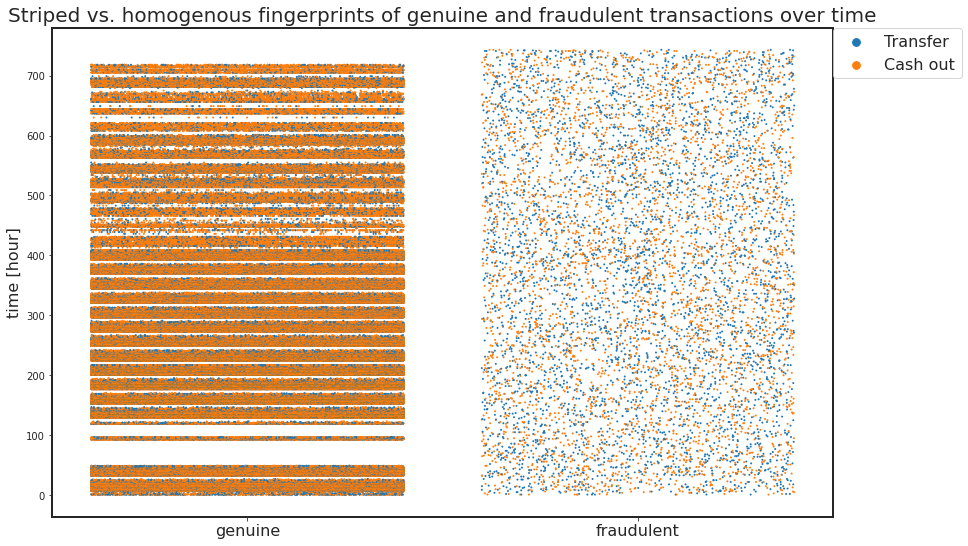

In [24]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

## 5. 2. Дисперсия по количеству

Два приведенных ниже графика показывают, что, хотя наличие мошенничества в транзакции можно распознать по исходной функции суммы, новая функция errorBalanceDest более эффективна для проведения различия.

C:\Users\NIKITA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


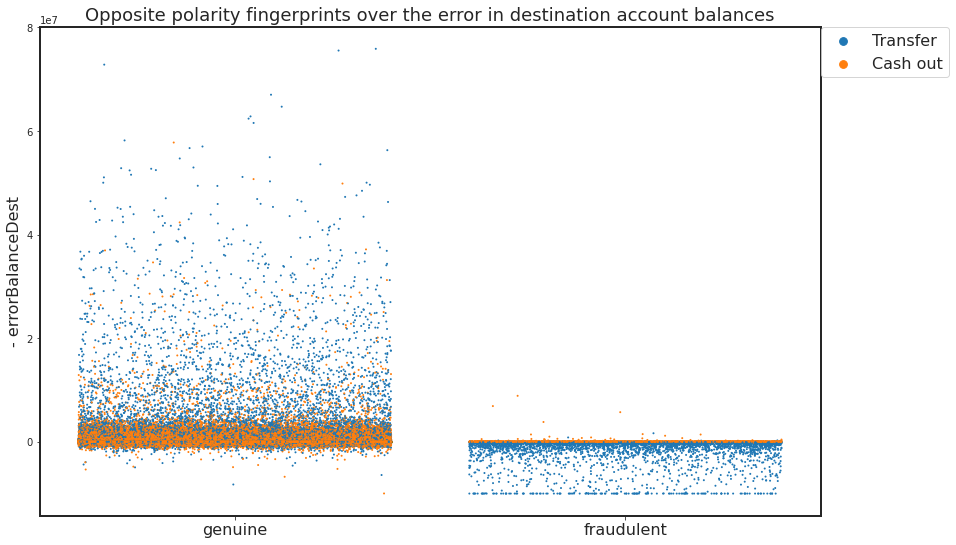

In [26]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

## 5. 3. Дисперсия по ошибке в балансе на целевых счетах

C:\Users\NIKITA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


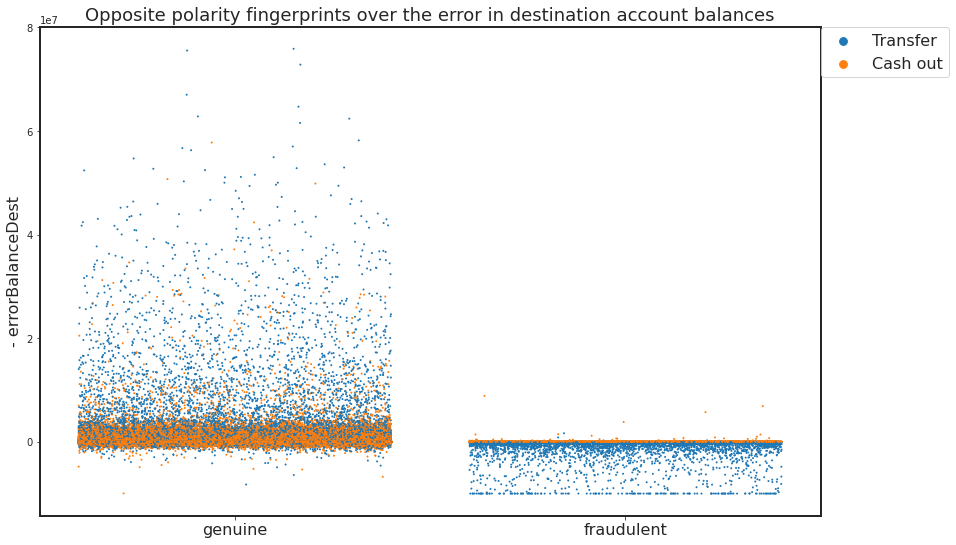

In [43]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

## 5. 4. Отделение подлинных транзакций от мошеннических

На приведенном ниже 3D-графике лучше всего различаются данные о мошенничестве и данные, не связанные с мошенничеством, с использованием обеих функций, основанных на ошибках. Очевидно, что первоначальная функция шага неэффективна для разделения мошенничества. Обратите внимание на полосатый характер подлинных данных по времени, который был получен из рисунка в разделе 5.1.

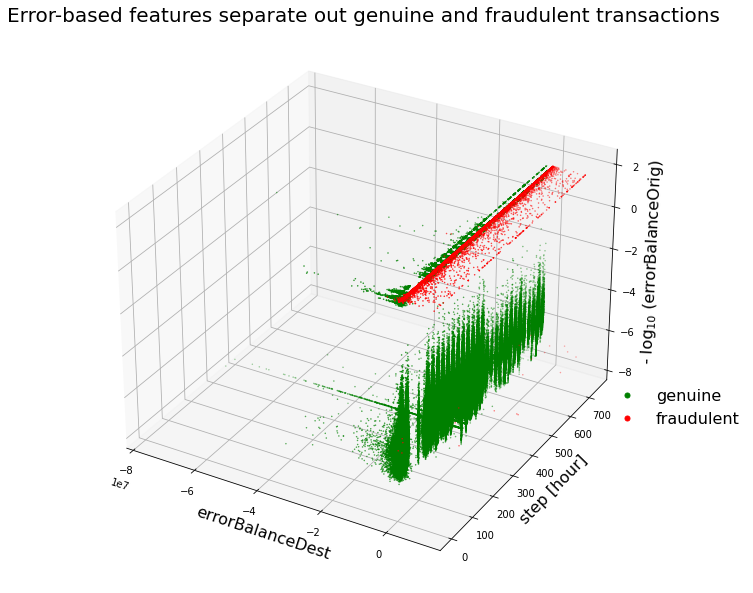

In [27]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

## 5. 5. Отпечатки пальцев подлинных и мошеннических транзакций

Дымящийся пистолет и всесторонние доказательства, встроенные в набор данных о разнице между мошенническими и подлинными транзакциями, получены путем изучения их соответствующих корреляций в приведенных ниже тепловых картах.

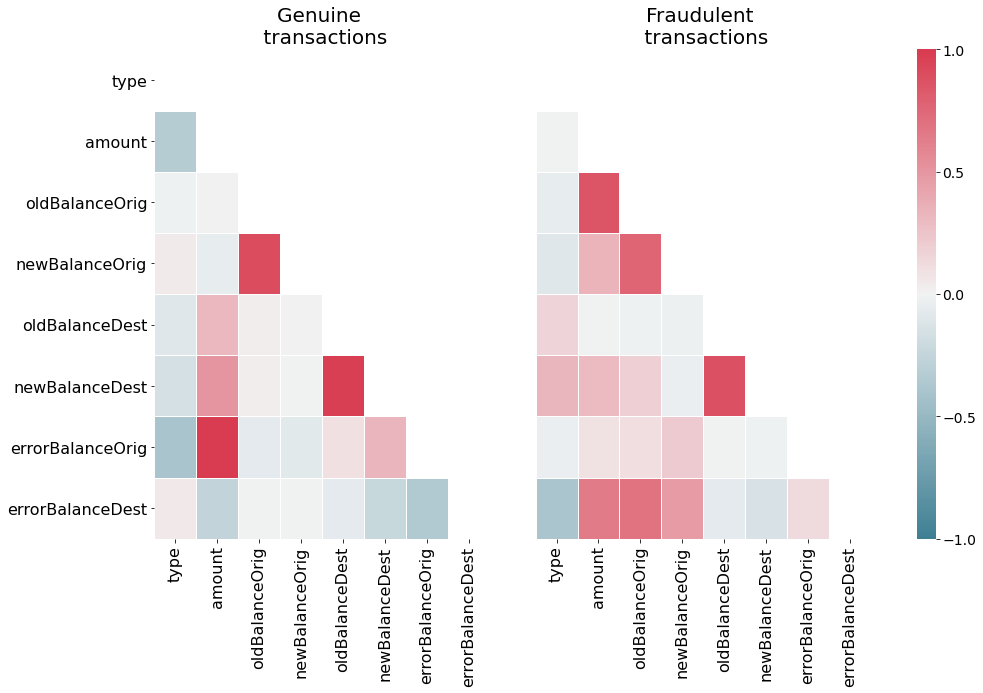

In [28]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

# 6. Машинное обучение для обнаружения мошенничества в искаженных данных

После получения доказательств из приведенных выше графиков о том, что данные теперь содержат функции, которые делают мошеннические транзакции четко обнаруживаемыми, оставшимся препятствием для обучения надежной модели ML является крайне несбалансированный характер данных.

In [29]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


Выбор метрики: Поскольку данные сильно искажены, я использую область под кривой точного отзыва (AUPRC), а не обычную область под рабочей характеристикой приемника (AUROC). Это связано с тем, что AUPRC более чувствителен к различиям между алгоритмами и их настройками параметров, чем AUROC (см. Davis and Goadrich, 2006).

Выбор алгоритма ML: Первый подход к работе с несбалансированными данными состоит в том, чтобы сбалансировать их, отбросив класс большинства перед применением алгоритма ML. Недостатком недостаточной выборки является то, что модель, обученная таким образом, не будет хорошо работать с реальными искаженными тестовыми данными, поскольку почти вся информация была отброшена. Лучшим подходом может быть чрезмерная выборка класса меньшинства, скажем, с помощью метода синтетической избыточной выборки меньшинства (SMOTE), содержащегося в библиотеке "imblearn". Мотивированный этим, я попробовал различные подходы к обнаружению аномалий и контролируемому обучению. Однако я нахожу, что наилучший результат достигается на исходном наборе данных с помощью алгоритма ML, основанного на ансамблях деревьев решений, которые по своей сути хорошо работают с несбалансированными данными. Такие алгоритмы не только позволяют построить модель, которая может справиться с недостающими значениями в наших данных, но и, естественно, позволяют ускорить процесс с помощью параллельной обработки. Среди этих алгоритмов алгоритм с экстремальным градиентом (XGBoost), используемый ниже, немного превосходит алгоритм случайного леса. Наконец, XGBoost, как и несколько других алгоритмов ML, позволяет больше взвешивать положительный класс по сравнению с отрицательным классом-параметр, который также позволяет учитывать перекос в данных.

Разделите данные на обучающие и тестовые наборы в соотношении 80:20

In [30]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [31]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))

C:\Users\NIKITA\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:49:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUPRC = 0.9983642588456605


## 6.1. Каковы важные функции для модели ML?

На рисунке ниже показано, что новая функция errorBalanceOrig, которую мы создали, является наиболее релевантной функцией для модели. Объекты упорядочиваются в зависимости от количества выборок, на которые повлияли разбиения на этих объектах.

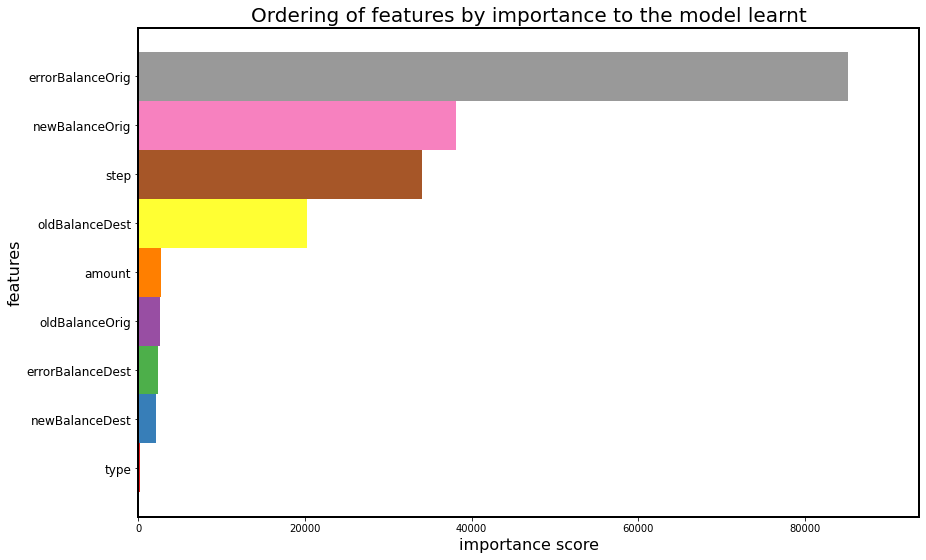

In [32]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

## 6.2. Визуализация модели ML

Корневой узел в дереве решений, визуализированном ниже, действительно является параметром errorBalanceOrig, как и следовало ожидать из его высокой значимости для модели.

In [2]:
df.to_csv(lab1)
df

NameError: name 'df' is not defined